<a href="https://colab.research.google.com/github/matheus-asilva/meetup_vv/blob/master/Machine_Learning_101_com_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Índice

1. Análise Exploratória de Dados, limpeza e feature engineering
2. Modelagem Preditiva, validação cruzada, tunning de hiperparâmetros e ensembling.
3. Submit do resultado no kaggle

## 1.1. Lendo bibliotecas

In [0]:
# Set google drive folder to working directory

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('gdrive/My Drive/Colab Notebooks/aifest')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
import plotly.offline as py     # Open source library for composing, editing, and sharing interactive data visualization 
from matplotlib import pyplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter

### Bibliotecas de machine learning
import xgboost as xgb  # Implementação do gradient boosting
import seaborn as sns  # Biblioteca de visualização de dados

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 1.2. Carregando datasets

### Definição das variáveis
* survival:	Sobreviveu -	0 = Não, 1 = Sim
* pclass: 	Classe do ticket - 1 = primeira classe, 2 = segunda classe, 3 = terceira classe
* sex:	Sexo	
* Age:	idade em anos
* sibsp:	# de filhos(as) / esposas dentro do titanic
* parch	# de pais / crianças dentro do titanic
* ticket:	número do ticket	
* fare: valor da tarifa	
* cabin:	número da cabine
* embarked:	Porto de embarque -	C = Cherbourg, Q = Queenstown, S = Southampton


In [0]:
# Carrega os dados de treino e teste
treino = pd.read_csv('data/train.csv')
teste  = pd.read_csv('data/test.csv')

# Salva os IDs numa lista
PassengerId = teste['PassengerId']

# Mostra as 5 primeiras linhas
treino.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
# Estatística descritiva de cada uma das variáveis numéricas
treino.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [0]:
# Tipo de cada variável
treino.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## 1.3. Objetivo da análise
A variável **Survived** é a nossa variável dependente, ou target. É uma variável binária com os valores 1 para "Sobreviveu" e 0 para "não sobreviveu".
**Todas as outras** são potenciais preditoras ou variáveis independentes. O objetico é prever essa variável dependente utilizando somente as variáveis independentes que temos disponíveis. O dataset de teste foi criado para testar nosso modelo.

## 1.4. Overview nos nossos dados

Text(0.5, 1.0, 'Número de Sobreviventes por Porto de Embarque')

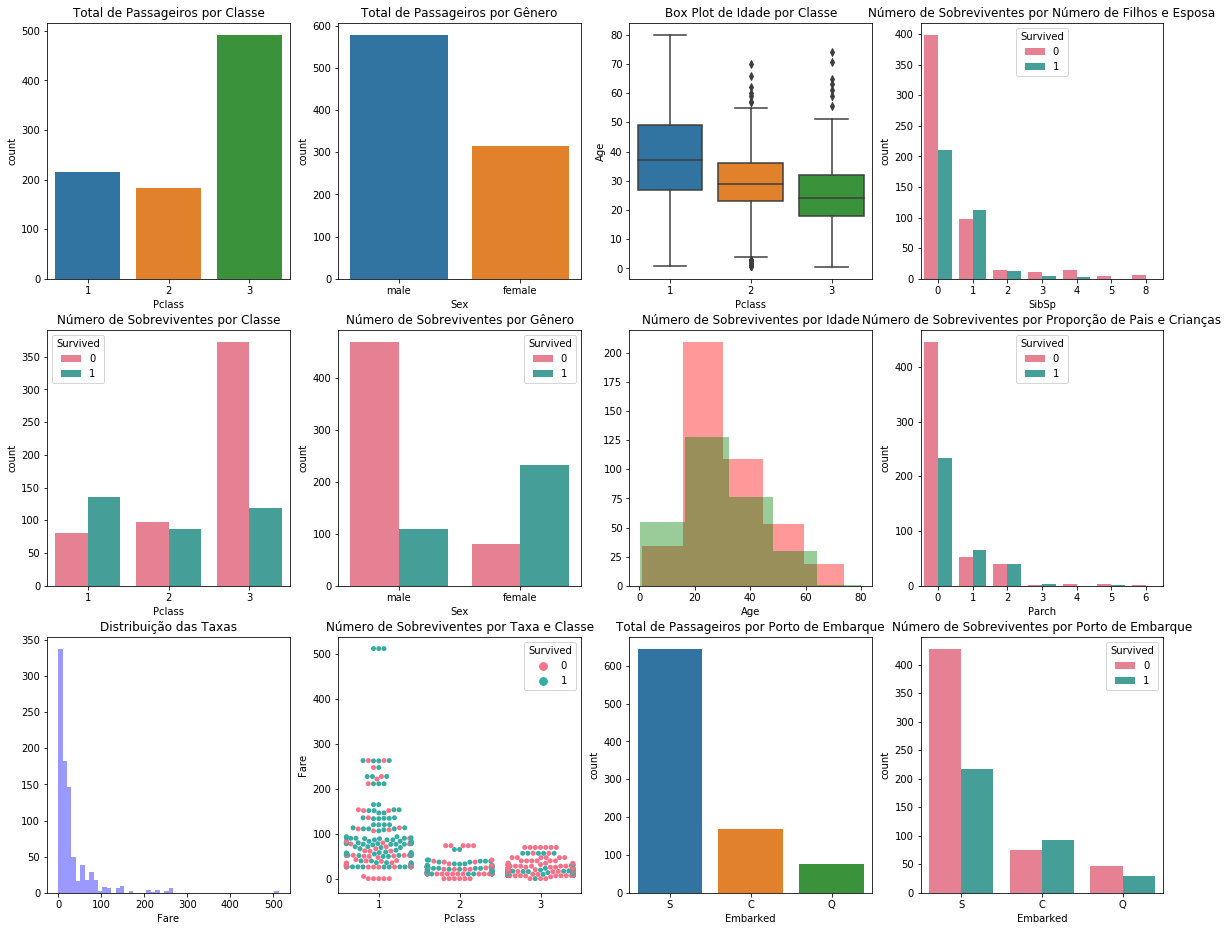

In [0]:
f,ax = plt.subplots(3,4,figsize=(20,16))
sns.countplot('Pclass',data=treino,ax=ax[0,0])
sns.countplot('Sex',data=treino,ax=ax[0,1])
sns.boxplot(x='Pclass',y='Age',data=treino,ax=ax[0,2])
sns.countplot('SibSp',hue='Survived',data=treino,ax=ax[0,3],palette='husl')
sns.distplot(treino['Fare'].dropna(),ax=ax[2,0],kde=False,color='b')
sns.countplot('Embarked',data=treino,ax=ax[2,2])

sns.countplot('Pclass',hue='Survived',data=treino,ax=ax[1,0],palette='husl')
sns.countplot('Sex',hue='Survived',data=treino,ax=ax[1,1],palette='husl')
sns.distplot(treino[treino['Survived']==0]['Age'].dropna(),ax=ax[1,2],kde=False,color='r',bins=5)
sns.distplot(treino[treino['Survived']==1]['Age'].dropna(),ax=ax[1,2],kde=False,color='g',bins=5)
sns.countplot('Parch',hue='Survived',data=treino,ax=ax[1,3],palette='husl')
sns.swarmplot(x='Pclass',y='Fare',hue='Survived',data=treino,palette='husl',ax=ax[2,1])
sns.countplot('Embarked',hue='Survived',data=treino,ax=ax[2,3],palette='husl')

ax[0,0].set_title('Total de Passageiros por Classe')
ax[0,1].set_title('Total de Passageiros por Gênero')
ax[0,2].set_title('Box Plot de Idade por Classe')
ax[0,3].set_title('Número de Sobreviventes por Número de Filhos e Esposa')
ax[1,0].set_title('Número de Sobreviventes por Classe')
ax[1,1].set_title('Número de Sobreviventes por Gênero')
ax[1,2].set_title('Número de Sobreviventes por Idade')
ax[1,3].set_title('Número de Sobreviventes por Proporção de Pais e Crianças')
ax[2,0].set_title('Distribuição das Taxas')
ax[2,1].set_title('Número de Sobreviventes por Taxa e Classe')
ax[2,2].set_title('Total de Passageiros por Porto de Embarque')
ax[2,3].set_title('Número de Sobreviventes por Porto de Embarque')

# 2. Análise Exploratória de Dados (EDA), Limpeza e Feature Engineering

## 2.1. Corrigindo e Tratando Missings
### Outliers
Ao analisar os dados, não parece ter nenhum tipo de dados estranho.

Porém existem alguns outliers em portencial que iremos ver:
* Criaremos uma função chamada `detectar_outliers`
* Para cada coluna do dataframe, essa função calcula o 25º percentil (Q1) e o 75º percentil (Q3).
* O intervalo interquartil (IQR) é uma medida de dispersão estatística, calculado pela diferença entre o Q3 e o Q1, chamados de limite superior e inferior entre os quartis.
* Qualquer valor fora de $1.5 \times IQR$ é considerado um outlier.

In [0]:
# Detecção de outliers 
def detectar_outliers(df, n, colunas):
    outlier_indices = []
    # itera em cada coluna
    for col in colunas:
        # 1º quartil (25%)
        Q1 = np.percentile(df[col],25)
        # 3º quartil (75%)
        Q3 = np.percentile(df[col],75)
        # Intervalo Interquartil (IQR)
        IQR = Q3 - Q1
        # Limite interquartil
        outlier_limite = 1.5 * IQR
        # Determina uma lista de índices dos outliers para a coluna
        outlier_list_col = df[(df[col] < Q1 - outlier_limite) | (df[col] > Q3 + outlier_limite )].index       
        # Appenda os índices os outliers na lista outlier_indices
        outlier_indices.extend(outlier_list_col)
        
    # seleciona as observações que contém mais do que 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiplos_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiplos_outliers   
# detecta os outliers de Age, SibSp , Parch e Fare
outliers_remover = detectar_outliers(treino, 2, ["Age","SibSp","Parch","Fare"])
treino.loc[outliers_remover]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


* Encontramos 10 outliers.
* PassengerID 28, 89 e 342 tem valor alto para Ticket Fare
* Os outros 7 tem valor alto para SibSP.

In [0]:
# Remove outliers
treino = treino.drop(outliers_remover, axis = 0).reset_index(drop=True)

### Tratando missings
A função `.info` mostra o quão completo ou incompleto os datasets estão.
Existem valores nulos, ou missings, nas variáveis age, cabin, e embarked. Missings podem nos dar trabalho porque alguns algoritmos não sabem como lider com esses valores e, por isso, irão quebrar. Por outro lado, algoritmos baseados em árvore lidam melhor com eles.

A nossa abordagem para tratar os missings é imputar com a média, mediana ou a média + um desvio padrão randomizado.

In [0]:
treino.info()
print('_'*40)
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## 2.2. Análise Descritiva (univariada) 

In [0]:
full_data = [treino, teste]
sobreviventes = treino['Survived']
sobreviventes.describe()

count    881.000000
mean       0.385925
std        0.487090
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

## 2.3 Feature Engineering - Análise Bi-variada

Uma das nossas primeiras tarefas na parte de Análise de Dados é **converter as variáveis em valores numéricos/ordinais**.
Essas são os vários tipos de dados

**a) Dados qualitativos: discretos**
* Nominais: sem ordem natural entre categorias. Por exemplo, Nome
* Categóricos: Sexo

**b) Dados numéricos ou quantitativos**
* Discretos: podem indicar ordem, como Classe, ou não como Sobrevivente.
* Contínuos: Idade

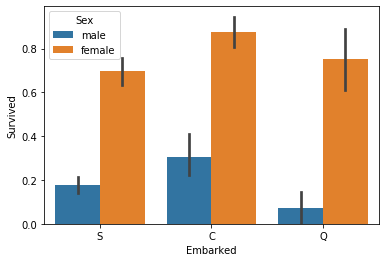

In [0]:
# Porto de Embarque
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=treino);

Porto de Embarque parece não indicar um impacto claro na taxa de sobrevivência.

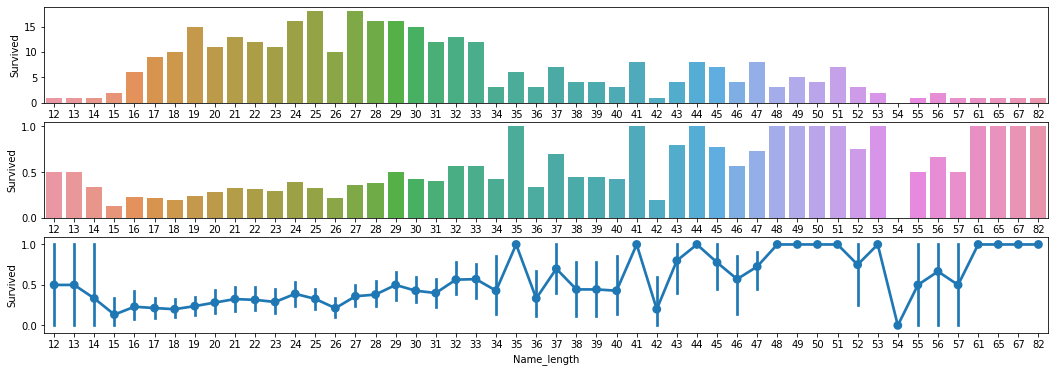

In [0]:
# Name_length - tamanho do nome
for dataset in full_data:
    dataset['Name_length'] = treino['Name'].apply(len)

soma_nome    = treino[["Name_length", "Survived"]].groupby(['Name_length'],as_index=False).sum()
media_nome   = treino[["Name_length", "Survived"]].groupby(['Name_length'],as_index=False).mean()
fig, (axis1, axis2, axis3) = plt.subplots(3,1, figsize=(18,6))
sns.barplot(x='Name_length', y='Survived', data=soma_nome, ax = axis1)
sns.barplot(x='Name_length', y='Survived', data=media_nome, ax = axis2)
sns.pointplot(x = 'Name_length', y = 'Survived', data=treino, ax = axis3)

In [0]:
treino.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24


O primeiro gráfico mostra a quantidade de pessoas que sobreviveram, por tamanho do nome.

O segundo mostra as médias das taxas de sobrevivência.

As categorias propostas são: menos que 23 (maioria homem), 24 a 28, 29 a 40, 41 pra mais (maioria mulher).
As categorias estão dimensionadas por grupo de passageiros com taxas semelhantes de sobrevivência.

In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Name_length'] <= 23, 'Name_length'] = 0
    dataset.loc[(dataset['Name_length'] > 23) & (dataset['Name_length'] <= 28), 'Name_length']  = 1
    dataset.loc[(dataset['Name_length'] > 28) & (dataset['Name_length'] <= 40), 'Name_length']  = 2
    dataset.loc[ dataset['Name_length'] > 40, 'Name_length'] = 3
treino['Name_length'].value_counts()

0    358
1    235
2    198
3     90
Name: Name_length, dtype: int64

### Sexo

In [0]:
for dataset in full_data: # mapeia sexo
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)    

### Idade

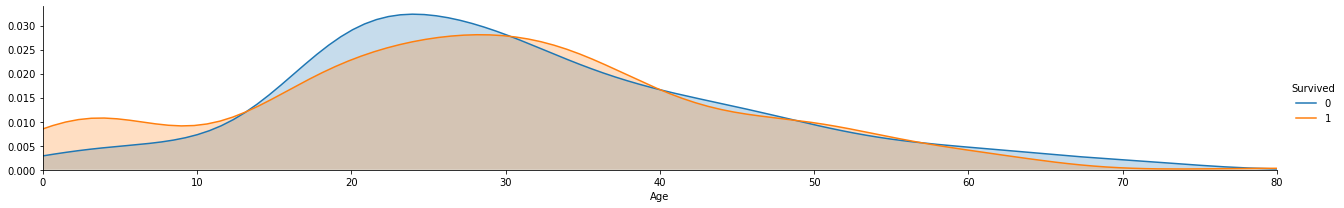

In [0]:
# Plota as distribuições de idade de quem sobreviveu ou não
a = sns.FacetGrid( treino, hue = 'Survived', aspect=6 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , treino['Age'].max()))
a.add_legend()

As melhores categorias para idade são:
* 0:  Menor que 14
* 1:  14 a 30
* 2:  30 a 40
* 3:  40 a 50
* 4:  50 a 60
* 5:  60 pra cima

In [0]:
for dataset in full_data:
    idade_avg = dataset['Age'].mean()
    idade_std = dataset['Age'].std()
    idade_null_count = dataset['Age'].isnull().sum()
    idade_null_random_list = np.random.randint(idade_avg - idade_std, idade_avg + idade_std, size=idade_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = idade_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 14, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 14) & (dataset['Age'] <= 30), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age'] = 2
    dataset.loc[ dataset['Age'] > 60, 'Age'] = 4
treino['Age'].value_counts()

5    431
1    212
3     96
0     78
2     42
4     22
Name: Age, dtype: int64

In [0]:
treino[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Age,Survived
0,0,0.576923
1,1,0.419811
3,3,0.406250
2,2,0.404762
5,5,0.336427
4,4,0.227273


### Familia: SibSp e Parch

Aqui criaremos uma variável nova chamada `FamilySize` (tamanho da familia)

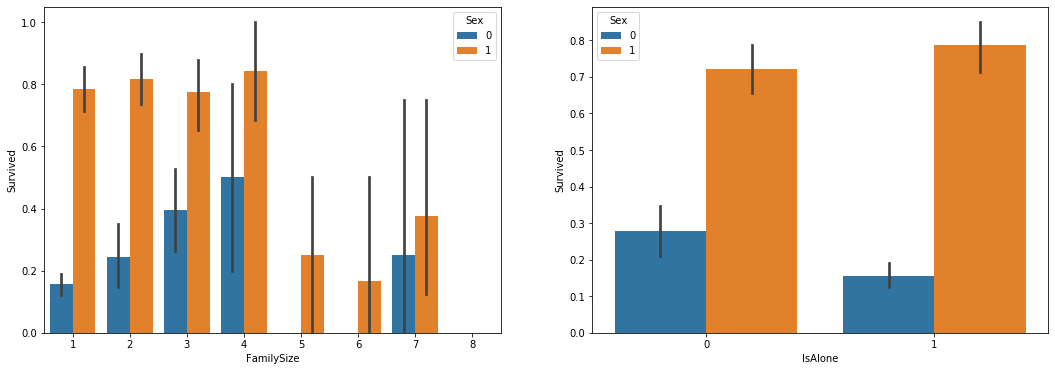

In [0]:
for dataset in full_data:
# Cria a variável FamilySize como uma combinação de SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']+1
# Cria a variável IsAlone a partir da FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Cria variável Boys e Girls a partir da FamilySize
    dataset['Boys'] = 0
    dataset.loc[(dataset['Age'] == 0) & (dataset['Sex']==0), 'Boys'] = 1

    dataset['Girls'] = 0
    dataset.loc[(dataset['Age'] == 0) & (dataset['Sex']==1), 'Girls'] = 1
    
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))
sns.barplot(x="FamilySize", y="Survived", hue="Sex", data=treino, ax = axis1);
sns.barplot(x="IsAlone", y="Survived", hue="Sex", data=treino, ax = axis2);

A variável IsAlone não nos mostra uma diferença significativa entre homem e mulher em qualquer direção, ou seja, ela não é uma boa preditora.

### Fare

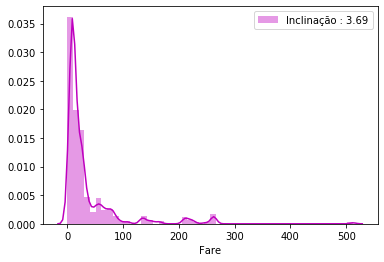

In [0]:
# Remove todos os valores nulos e cria uma variável categórica para Fare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(treino['Fare'].median())

# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Inclinação : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

**Observations**
* Vemos que a distribuição da variável Fare está bem inclinada para a esqueda. Isso pode enviesar o modelo para valores bem altos de Fare.
* Nesse caso, transformaremos ele com a função logarítmica para reduzir a inclinação e redistribuir os dados.

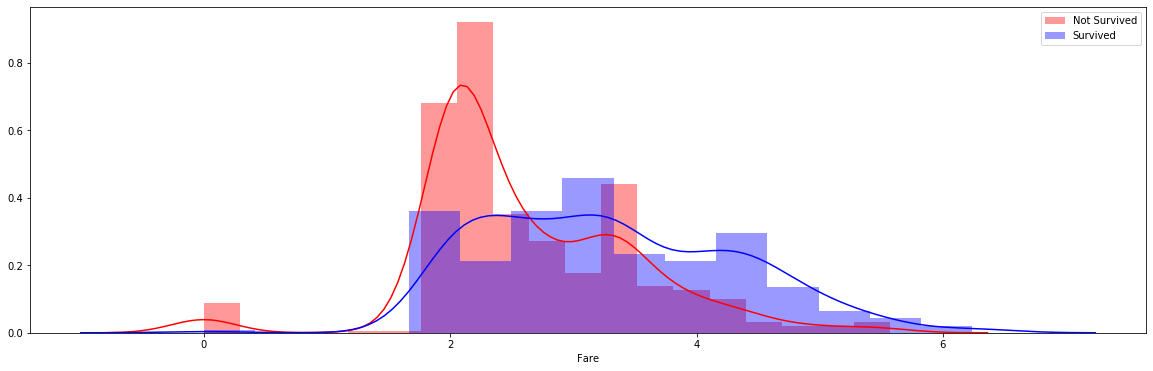

In [0]:
# Apply log to Fare to reduce skewness distribution
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
a4_dims = (20, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.distplot(treino["Fare"][treino["Survived"] == 0], color="r", label="Inclinação : %.2f"%(treino["Fare"].skew()), ax=ax)
g = sns.distplot(treino["Fare"][treino["Survived"] == 1], color="b", label="Inclinação : %.2f"%(treino["Fare"].skew()))
g = g.legend(["Not Survived","Survived"])

**Observação**
Categorias de Log Fare são:
* 0 a 2.7: menos sobreviventes
* Mais do que 2.7 mais sobreviventes

In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 2.7, 'Fare'] = 0
    dataset.loc[ dataset['Fare'] > 2.7, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
treino['Fare'].value_counts()

0    457
3    424
Name: Fare, dtype: int64

### Cabin

In [0]:
# Variável que diz se um passageiro tem uma cabine no navio (O se não tiver número, 1 caso tiver)
for dataset in full_data:
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

treino[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).sum().sort_values(by='Survived', ascending=False)

,Has_Cabin,Survived
0,0,206
1,1,134


In [0]:
treino[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Has_Cabin,Survived
1,1,0.666667
0,0,0.302941


Parece que ver se tem cabine ou não tem um forte impacto na taxa de sobrevivência.

### Embarked

In [0]:
for dataset in full_data:
# Remove os nulos da Embarked
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Mapeia Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
treino_pivot = pd.pivot_table(treino, values= 'Survived',index=['Embarked'],columns='Pclass',aggfunc=np.mean, margins=True)
def color_negative_vermelho(val):
    # Pega um escalar e retorna uma string com uma propriedade css
    color = 'red' if val < 0.4 else 'black'
    return 'color: %s' % color
treino_pivot = treino_pivot.style.applymap(color_negative_vermelho)
treino_pivot

Pclass,1,2,3,All
Embarked,,,,
0,0.587302,0.463415,0.193642,0.341195
1,0.694118,0.529412,0.378788,0.553571
2,0.5,0.666667,0.375,0.38961
All,0.629108,0.472826,0.245868,0.385925


Independente da classe, os passageiros que embarcaram na 0 (S) e 2 (Q) têm baixa chance de sobreviver

In [0]:
dataset['Embarked'] = dataset['Embarked'].replace(['0', '2'], '0')
treino['Fare'].value_counts()

0    457
3    424
Name: Fare, dtype: int64

### Títulos

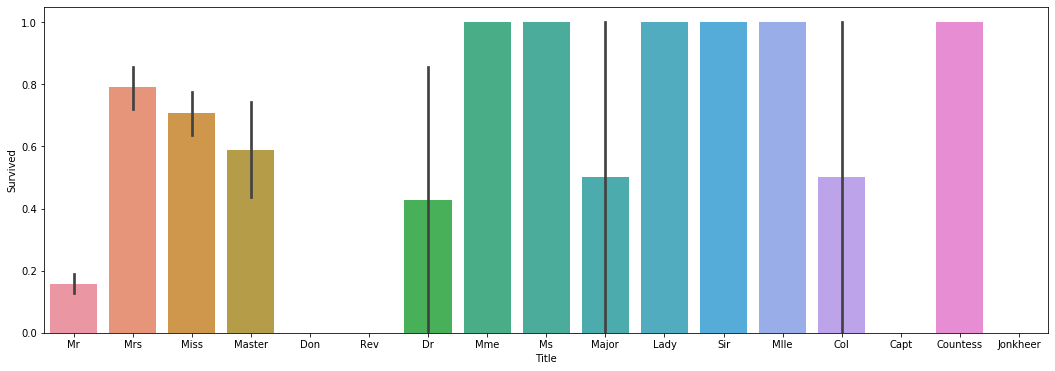

In [0]:
# Define função que extrai os titulos dos nomes dos passageiros
def define_titulo(nome):
    titulo_busca = re.search(' ([A-Za-z]+)\.', nome)
 # Se o título existe, extrai ele.
    if titulo_busca:
        return titulo_busca.group(1)
    return ""
for dataset in full_data:
# Cria a variável
    dataset['Title'] = dataset['Name'].apply(define_titulo)

fig, (axis1) = plt.subplots(1,figsize=(18,6))
sns.barplot(x="Title", y="Survived", data=treino, ax=axis1);

Existem 4 tipos de títulos:
0. Mme, Ms, Lady, Sir, Mlle, Countess: 100%. 
1. Mrs, Miss: around 70% de sobreviver
2. Master: por volta de 60%
3. Don, Rev, Capt, Jonkheer: sem informação
4. Dr, Major, Col: por volta de 40%
5. Mr: menos que 20%

In [0]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Mrs', 'Miss'], 'MM')
    dataset['Title'] = dataset['Title'].replace(['Dr', 'Major', 'Col'], 'DMC')
    dataset['Title'] = dataset['Title'].replace(['Don', 'Rev', 'Capt', 'Jonkheer'],'DRCJ')
    dataset['Title'] = dataset['Title'].replace(['Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'Countess'],'MMLSMC' )
# Mapeia titulo
    map_titulo = {"MM": 1, "Master":2, "Mr": 5, "DMC": 4, "DRCJ": 3, "MMLSMC": 0}
    dataset['Title'] = dataset['Title'].map(map_titulo)
    dataset['Title'] = dataset['Title'].fillna(3)

In [0]:
treino[["Title", "Survived"]].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
0,0,1.000000
1,1,0.741722
2,2,0.589744
4,4,0.454545
5,5,0.157895
3,3,0.000000


### Extrair deque da cabine
Uma cabine que tem o valor ‘C123’, a letra se refere ao deque da cabine.
Portanto iremos extrair essa informação e criar uma variável nova. Os missings serão preenchidos com zero.

In [0]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
for dataset in full_data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 
treino['Deck'].value_counts()

8    680
3     56
2     47
4     33
5     32
1     15
6     13
7      4
0      1
Name: Deck, dtype: int64

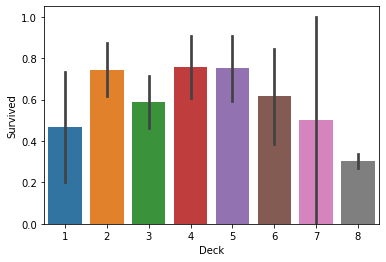

In [0]:
sns.barplot(x = 'Deck', y = 'Survived', order=[1,2,3,4,5,6,7,8], data=treino)

3 tipos de deque: 1 com 15 passageiros, 2 a 6, e 7 e 8 (maioria dos passageiros)

In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Deck'] <= 1, 'Deck'] = 1
    dataset.loc[(dataset['Deck'] > 1) & (dataset['Deck'] <= 6), 'Deck']  = 3
    dataset.loc[ dataset['Deck'] > 6, 'Deck'] = 0
treino[["Deck", "Survived"]].groupby(['Deck'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Deck,Survived
2,3,0.690608
1,1,0.437500
0,0,0.304094


## 2.4 Olhando o novo dataset

In [0]:
teste.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,FamilySize,IsAlone,Boys,Girls,Has_Cabin,Title,Deck
0,892,3,"Kelly, Mr. James",0,1,0,0,330911,0,U0,2,0,1,1,0,0,0,5.0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,3,1,0,363272,0,U0,0,3,2,0,0,0,0,1.0,0
2,894,2,"Myles, Mr. Thomas Francis",0,4,0,0,240276,0,U0,2,0,1,1,0,0,0,5.0,0
3,895,3,"Wirz, Mr. Albert",0,5,0,0,315154,0,U0,0,3,1,1,0,0,0,5.0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,5,1,1,3101298,0,U0,0,1,3,0,0,0,0,1.0,0


In [0]:
treino.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,FamilySize,IsAlone,Boys,Girls,Has_Cabin,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",0,5,1,0,A/5 21171,0,U0,0,0,2,0,0,0,0,5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,1,0,PC 17599,3,C85,1,3,2,0,0,0,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,5,0,0,STON/O2. 3101282,0,U0,0,0,1,1,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,1,0,113803,3,C123,0,3,2,0,0,0,1,1,3
4,5,0,3,"Allen, Mr. William Henry",0,1,0,0,373450,0,U0,0,1,1,1,0,0,0,5,0


## 2.5. Estatística descritiva

In [0]:
treino.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,FamilySize,IsAlone,Boys,Girls,Has_Cabin,Title,Deck
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,0.350738,3.208854,0.455165,0.363224,1.443814,0.365494,1.022701,1.818388,0.609535,0.044268,0.044268,0.228150,3.423383,0.634506
std,256.617021,0.487090,0.835055,0.477472,1.936366,0.871571,0.791839,1.499799,0.638100,1.019997,1.382086,0.488132,0.205806,0.205806,0.419878,1.911413,1.210893
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,448.000000,0.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,668.000000,1.000000,3.000000,1.000000,5.000000,1.000000,0.000000,3.000000,1.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,5.000000,5.000000,6.000000,3.000000,2.000000,3.000000,8.000000,1.000000,1.000000,1.000000,1.000000,5.000000,3.000000


# 3. Análise de correlação

## 3.1. Análise de Correlação com histogramas e pivot-tables

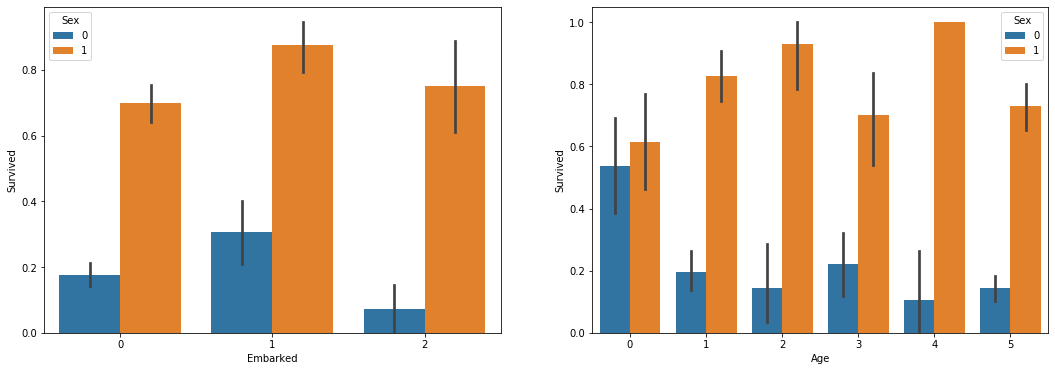

In [0]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=treino, ax = axis1);
sns.barplot(x="Age", y="Survived", hue="Sex", data=treino, ax = axis2);

In [0]:
treino[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000


In [0]:
for dataset in full_data:
    dataset['Gender_Embarked'] = 0
    dataset.loc[(dataset['Sex']==0) & (dataset['Embarked']==0), 'Gender_Embarked'] = 0
    dataset.loc[(dataset['Sex']==0) & (dataset['Embarked']==2), 'Gender_Embarked'] = 1
    dataset.loc[(dataset['Sex']==0) & (dataset['Embarked']==1), 'Gender_Embarked'] = 2
    dataset.loc[(dataset['Sex']==1) & (dataset['Embarked']==2), 'Gender_Embarked'] = 3
    dataset.loc[(dataset['Sex']==1) & (dataset['Embarked']==0), 'Gender_Embarked'] = 4
    dataset.loc[(dataset['Sex']==1) & (dataset['Embarked']==1), 'Gender_Embarked'] = 5
treino[["Gender_Embarked", "Survived"]].groupby(['Gender_Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Gender_Embarked,Survived
5,5,0.876712
3,3,0.750000
4,4,0.700000
2,2,0.305263
0,0,0.176606
1,1,0.073171


In [0]:
treino_pivot = pd.pivot_table(treino, values= 'Survived',index=['Title', 'Pclass'],columns='Sex',aggfunc=np.mean, margins=True)
def color_negative_vermelho(val):
    color = 'red' if val < 0.4 else 'black'
    return 'color: %s' % color
treino_pivot = treino_pivot.style.applymap(color_negative_vermelho)
treino_pivot

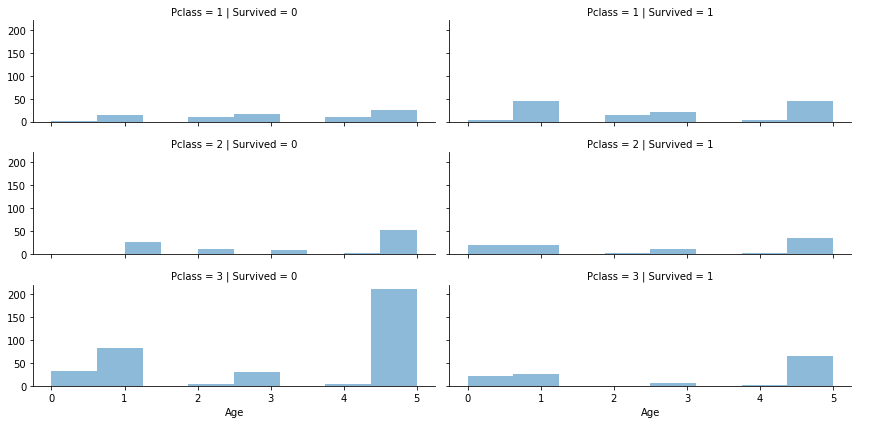

In [0]:
grid = sns.FacetGrid(treino, col='Survived', row='Pclass', size=2, aspect=3)
grid.map(plt.hist, 'Age', alpha=.5, bins=8)
grid.add_legend();

**Observações: aqui temos os sobreviventes!**
1. Familia com o tamanho 3 ou 4 da primeira pivot
2. Mulheres e homens sozinhos na primeira classe (segunda pivot)
3. No gráfico superior direito: primeira classe e idade categórica 1 e 2

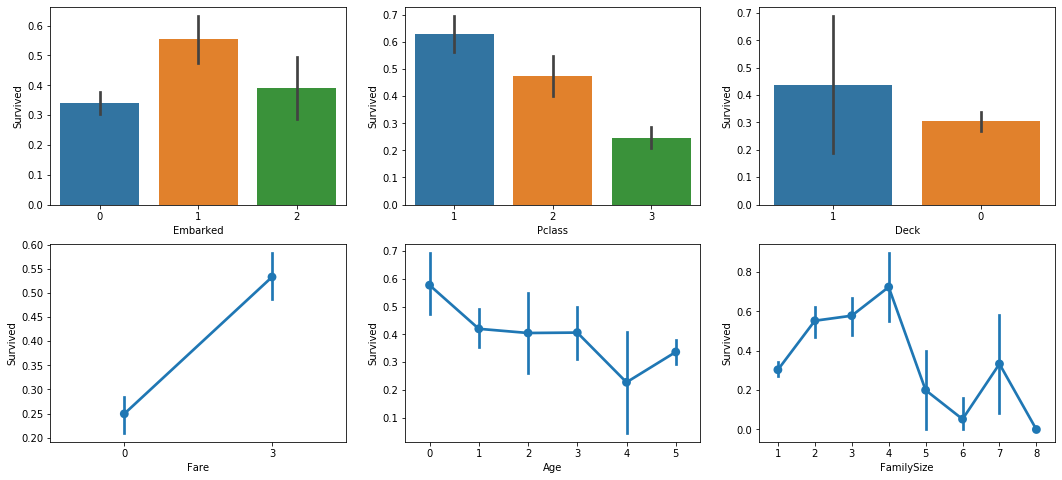

In [0]:
fig, saxis = plt.subplots(2, 3,figsize=(18,8))

sns.barplot(x = 'Embarked', y = 'Survived', data=treino, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=treino, ax = saxis[0,1])
sns.barplot(x = 'Deck', y = 'Survived', order=[1,0], data=treino, ax = saxis[0,2])

sns.pointplot(x = 'Fare', y = 'Survived',  data=treino, ax = saxis[1,0])
sns.pointplot(x = 'Age', y = 'Survived',  data=treino, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=treino, ax = saxis[1,2])

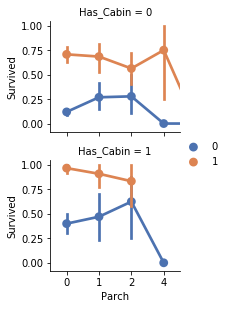

In [0]:
grid = sns.FacetGrid(treino, row='Has_Cabin', size=2.2, aspect=1.2)
grid.map(sns.pointplot, 'Parch', 'Survived', 'Sex', palette='deep')
grid.add_legend()

**Observações:**
* As cores representam: azul = 0 para homem, 1 para mulher
* Claramente mulher tem mais chance de sobreviver


## 3.2. Dropar variáveis

In [0]:
drop_vars = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Boys', 'IsAlone', 'Embarked']

treino = treino.drop(drop_vars, axis = 1)
teste  = teste.drop(drop_vars, axis = 1)

## 3.3. Correlação de Pearson

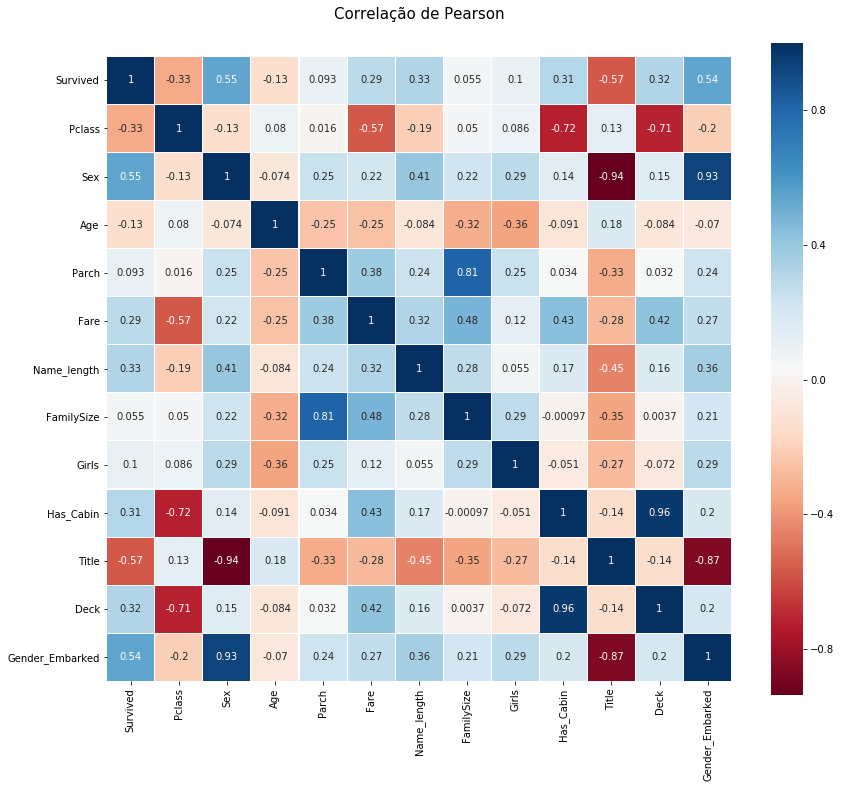

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlação de Pearson', y=1.05, size=15)
sns.heatmap(treino.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# 4. Modelagem preditiva, validação cruzada, tunning de hiperparâmetros e ensembling

* 4.1. Logistic Regression
* 4.2. Support Vector Machines (supervised)
* 4.3. k-Nearest Neighbors algorithm (k-NN)
* 4.4. Naive Bayes classifier
* 4.5. Perceptron
* 4.6 Linear SVC
* 4.7 Stochastic Gradient Descent
* 4.8. Decision tree
* 4.9 Random Forrest
* 4.10 Model summary
* 4.11. Model cross-validation with K-Fold
* 4.12 Hyperparameter tuning & learning curves for selected classifiers
* 4.13 Selecting and combining the best classifiers
* 4.14 Ensembling

In [0]:
X_treino, X_val, y_treino, y_val = train_test_split(treino.drop('Survived', axis=1), treino['Survived'], test_size=.3, random_state=42)

## 4.1. Logistic Regression

In [0]:
logreg = LogisticRegression()
logreg.fit(X_treino, y_treino)
y_pred1 = logreg.predict(X_val)
acc_log = round(logreg.score(X_val, y_val) * 100, 2)
acc_log

80.38

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_val, y_pred1))
cm = pd.DataFrame(confusion_matrix(y_val, y_pred1), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       159
           1       0.75      0.75      0.75       106

    accuracy                           0.80       265
   macro avg       0.80      0.80      0.80       265
weighted avg       0.80      0.80      0.80       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 133                   26
Actual: SURVIVED             26                   80


## 4.2. Support Vector Machines (supervised)

In [0]:
svc=SVC()
svc.fit(X_treino, y_treino)
y_pred2 = svc.predict(X_val)
acc_svc = round(svc.score(X_val, y_val) * 100, 2)
acc_svc

81.51

In [0]:
print(classification_report(y_val, y_pred2))
cm = pd.DataFrame(confusion_matrix(y_val, y_pred2), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       159
           1       0.79      0.73      0.76       106

    accuracy                           0.82       265
   macro avg       0.81      0.80      0.80       265
weighted avg       0.81      0.82      0.81       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 139                   20
Actual: SURVIVED             29                   77


## 4.3. k-Nearest Neighbors algorithm (k-NN)

In [0]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=10, p=2, 
                           weights='uniform')
knn.fit(X_treino, y_treino)
knn_predictions = knn.predict(X_val)
acc_knn = round(knn.score(X_val, y_val) * 100, 2)
acc_knn

80.75

In [0]:
print(classification_report(y_val, knn_predictions))
cm = pd.DataFrame(confusion_matrix(y_val, knn_predictions), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       159
           1       0.80      0.69      0.74       106

    accuracy                           0.81       265
   macro avg       0.81      0.79      0.79       265
weighted avg       0.81      0.81      0.80       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 141                   18
Actual: SURVIVED             33                   73


[13, 0.7941176470588235]


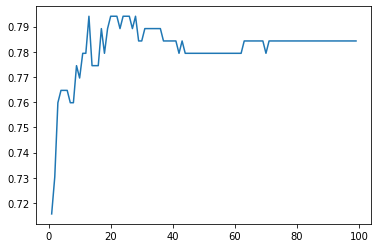

In [0]:
## Selecting the right n_neighbors for the k-NN classifier
x_trainknn, x_testknn, y_trainknn, y_testknn = train_test_split(X_treino,y_treino,test_size = .33, random_state = 0)
nn_scores = []
best_prediction = [-1,-1]
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='minkowski', p =2)
    knn.fit(x_trainknn, y_trainknn)
    score = accuracy_score(y_testknn, knn.predict(x_testknn))
    #print i, score
    if score > best_prediction[1]:
        best_prediction = [i, score]
    nn_scores.append(score)
print (best_prediction)
plt.plot(range(1,100),nn_scores)

## 4.4. Naive Bayes classifier

In [0]:
gaussian = GaussianNB()
gaussian.fit(X_treino, y_treino)
y_pred3 = gaussian.predict(X_val)
acc_gaussian = round(gaussian.score(X_val, y_val) * 100, 2)
acc_gaussian

79.62

In [0]:
print(classification_report(y_val, y_pred3))
cm = pd.DataFrame(confusion_matrix(y_val, y_pred3), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       159
           1       0.71      0.83      0.77       106

    accuracy                           0.80       265
   macro avg       0.79      0.80      0.79       265
weighted avg       0.81      0.80      0.80       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 123                   36
Actual: SURVIVED             18                   88


## 4.5. Perceptron

In [0]:
perceptron = Perceptron()
perceptron.fit(X_treino, y_treino)
y_pred4 = perceptron.predict(X_val)
acc_perceptron = round(perceptron.score(X_val, y_val) * 100, 2)
acc_perceptron

75.85

In [0]:
print(classification_report(y_val, y_pred4))
cm = pd.DataFrame(confusion_matrix(y_val, y_pred4), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       159
           1       0.76      0.58      0.66       106

    accuracy                           0.76       265
   macro avg       0.76      0.73      0.74       265
weighted avg       0.76      0.76      0.75       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 139                   20
Actual: SURVIVED             44                   62


## 4.6. Linear SVC

In [0]:
linear_svc = LinearSVC()
linear_svc.fit(X_treino, y_treino)
Y_pred5 = linear_svc.predict(X_val)
acc_linear_svc = round(linear_svc.score(X_val, y_val) * 100, 2)
acc_linear_svc

80.0

In [0]:
print(classification_report(y_val, Y_pred5))
cm = pd.DataFrame(confusion_matrix(y_val, Y_pred5), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       159
           1       0.75      0.75      0.75       106

    accuracy                           0.80       265
   macro avg       0.79      0.79      0.79       265
weighted avg       0.80      0.80      0.80       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 133                   26
Actual: SURVIVED             27                   79


## 4.7. Stochastic Gradient Descent (sgd)

In [0]:
sgd = SGDClassifier()
sgd.fit(X_treino, y_treino)
Y_pred6 = sgd.predict(X_val)
acc_sgd = round(sgd.score(X_val, y_val) * 100, 2)
acc_sgd

74.34

In [0]:
print(classification_report(y_val, Y_pred6))
cm = pd.DataFrame(confusion_matrix(y_val, Y_pred6), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       159
           1       0.65      0.76      0.70       106

    accuracy                           0.74       265
   macro avg       0.74      0.75      0.74       265
weighted avg       0.75      0.74      0.75       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 116                   43
Actual: SURVIVED             25                   81


## 4.8. Decision tree


In [0]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_treino, y_treino)
Y_pred7 = decision_tree.predict(X_val)
acc_decision_tree = round(decision_tree.score(X_val, y_val) * 100, 2)
acc_decision_tree

79.25

In [0]:
print(classification_report(y_val, Y_pred7))
cm = pd.DataFrame(confusion_matrix(y_val, Y_pred7), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       159
           1       0.77      0.69      0.73       106

    accuracy                           0.79       265
   macro avg       0.79      0.78      0.78       265
weighted avg       0.79      0.79      0.79       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 137                   22
Actual: SURVIVED             33                   73


## 4.9. Random Forests

In [0]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_treino, y_treino)
random_forest_predictions = random_forest.predict(X_val)
acc_random_forest = round(random_forest.score(X_val, y_val) * 100, 2)
acc_random_forest

80.38

In [0]:
print(classification_report(y_val, random_forest_predictions))
cm = pd.DataFrame(confusion_matrix(y_val, random_forest_predictions), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       159
           1       0.79      0.69      0.74       106

    accuracy                           0.80       265
   macro avg       0.80      0.78      0.79       265
weighted avg       0.80      0.80      0.80       265

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 140                   19
Actual: SURVIVED             33                   73


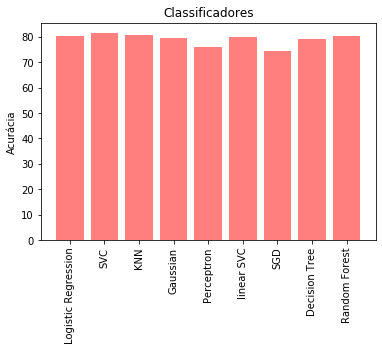

In [0]:
objects = ('Logistic Regression', 'SVC', 'KNN', 'Gaussian', 'Perceptron', 'linear SVC', 'SGD', 'Decision Tree', 'Random Forest')
x_pos = np.arange(len(objects))
accuracies1 = [acc_log, acc_svc, acc_knn, acc_gaussian, acc_perceptron, acc_linear_svc, acc_sgd, acc_decision_tree, acc_random_forest]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Acurácia')
plt.title('Classificadores')
plt.show()

## 4.11. Validação Cruzada com K-Fold

![Cross-validation process:](https://image.slidesharecdn.com/kagglesharingmarkpeng20151216finalpresented-151216161621/95/general-tips-for-participating-kaggle-competitions-13-638.jpg?cb=1452565877)
### Scores de Validação Cruzada

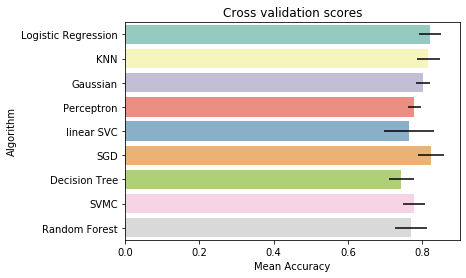

In [0]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5)

random_state = 2

classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(GaussianNB())
classifiers.append(Perceptron(random_state=random_state))
classifiers.append(LinearSVC(random_state=random_state))
classifiers.append(SGDClassifier(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_treino, y = y_treino, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":['Logistic Regression',  'KNN', 'Gaussian',
    'Perceptron', 'linear SVC', 'SGD', 'Decision Tree','SVMC', 'Random Forest']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## 4.12 Tunning de hiperparâmetros

In [0]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_treino, y_treino)
adaDTC_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    3.6s finished


0.7857142857142857

In [0]:
# ExtraTrees 
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 7],
              "min_samples_leaf": [1, 3, 7],
              "bootstrap": [False],
              "n_estimators" :[300,600],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_treino, y_treino)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  2.0min finished


0.827922077922078

In [0]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] }
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_treino, y_treino)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   23.8s finished


0.8068181818181818

In [0]:
# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1,10,50,100,200,300, 1000]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(X_treino, y_treino)
SVMC_best = gsSVMC.best_estimator_
# Best score
gsSVMC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 133 out of 140 | elapsed:    7.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    7.7s finished


0.8198051948051948

In [0]:
# Random Forest
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 7],
              "min_samples_leaf": [1, 3, 7],
              "bootstrap": [False],
              "n_estimators" :[300,600],
              "criterion": ["gini"]}
gsrandom_forest = GridSearchCV(random_forest,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsrandom_forest.fit(X_treino, y_treino)
# Best score
random_forest_best = gsrandom_forest.best_estimator_
gsrandom_forest.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  2.1min finished


0.8311688311688312

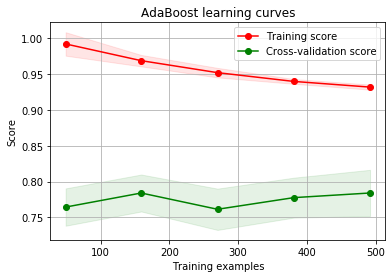

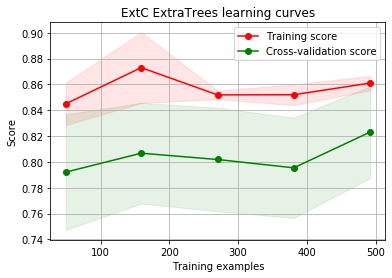

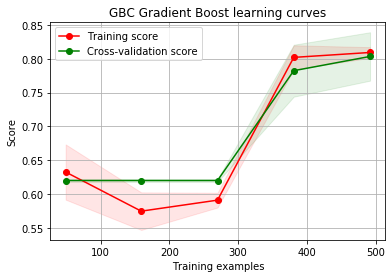

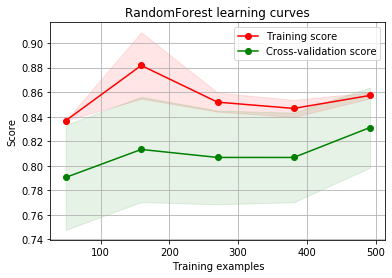

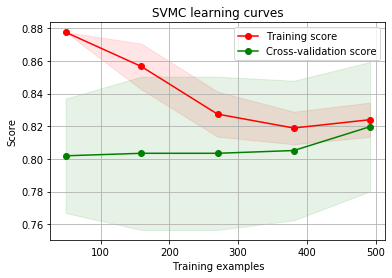

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_treino, y_treino,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtC ExtraTrees learning curves",X_treino, y_treino,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GBC Gradient Boost learning curves",X_treino, y_treino,cv=kfold)
g = plot_learning_curve(gsrandom_forest.best_estimator_,"RandomForest learning curves",X_treino, y_treino,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVMC learning curves",X_treino, y_treino,cv=kfold)

## 4.13 Selecionando e combinando os melhores classificadores


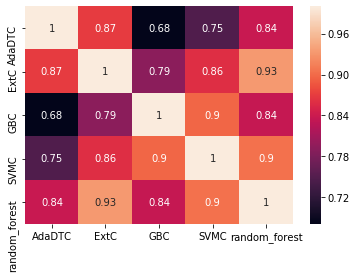

In [0]:
test_Survived_AdaDTC = pd.Series(adaDTC_best.predict(X_val), name="AdaDTC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_val), name="ExtC")
test_Survived_GBC = pd.Series(GBC_best.predict(X_val), name="GBC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_val), name="SVMC")
test_Survived_random_forest = pd.Series(random_forest_best.predict(X_val), name="random_forest")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_AdaDTC, test_Survived_ExtC, test_Survived_GBC,test_Survived_SVMC,test_Survived_random_forest],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

## 4.14 Ensembling

In [0]:
VotingPredictor = VotingClassifier(estimators=[('ExtC', ExtC_best), ('GBC',GBC_best),
('SVMC', SVMC_best), ('random_forest', random_forest_best)], voting='soft', n_jobs=4)
VotingPredictor = VotingPredictor.fit(X_treino, y_treino)

## 4.15. Sumário das variáveis mais importantes

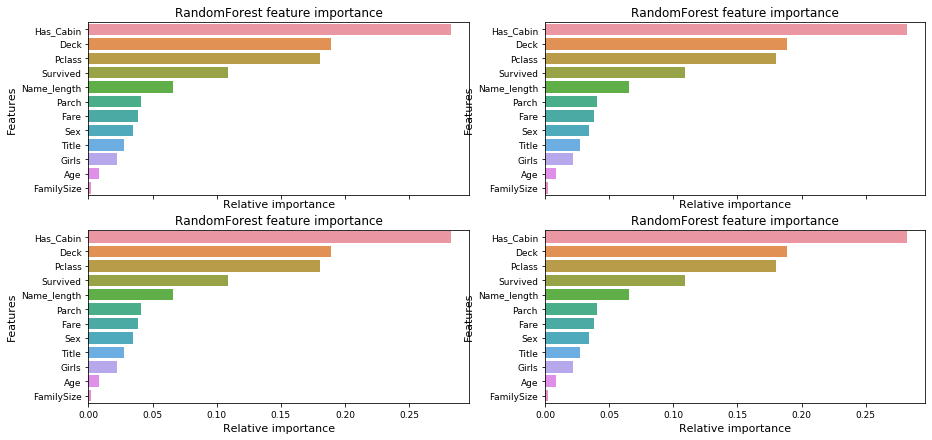

In [0]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,7))
names_classifiers = [("AdaBoosting", adaDTC_best),
("GradientBoosting",GBC_best), ("RandomForest",random_forest_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        # name = names_classifiers[nclassifier][0]
        # classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=treino.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=11)
        g.set_ylabel("Features",fontsize=11)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1